<H2 style="text-align: left">Requirements</H2>
<p>Installation of required libraries</p>

In [ ]:
%pip install datasets
%pip install torchmetrics
%pip install gensim

<H3 style="text-align: left">Imports</H3>
<p>All the libraries used during this project</p>

In [206]:
import torch
import torchmetrics
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from collections import defaultdict
import numpy as np
from gensim import downloader
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay, f1_score
from datasets import load_dataset

<p>Set seed for reproducing results and healthy comparison of experimentations</p>

In [207]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

<p>Loading the dataset from HuggingFace</p>

In [208]:
mydataset = load_dataset("surrey-nlp/PLOD-CW")

<H2 style="text-align: left">Data Analysis</H2>
<p>Acquisition of all the used table, statistics and figures in Q1 of the project report, data analysis and visualisation.</p>

              B-O  B-AC  B-LF  I-LF Longforms
Train       32971  2336  1462  3231      4693
Test         4292   270   150   288       438
Validation   4261   263   149   327       476
Total       41524  2869  1761  3846      5607
Number of sequences of tokens in train split: 1072
Number of sequences of tokens in validation split: 126
Number of sequences of tokens in test split: 153
Number of unknown tokens in test dataset: 859
Number of unknown tokens in validation dataset: 829
__________
Number of tokens in train dataset: 40000
Number of tokens in test dataset: 5000
Number of tokens in validation dataset: 5000


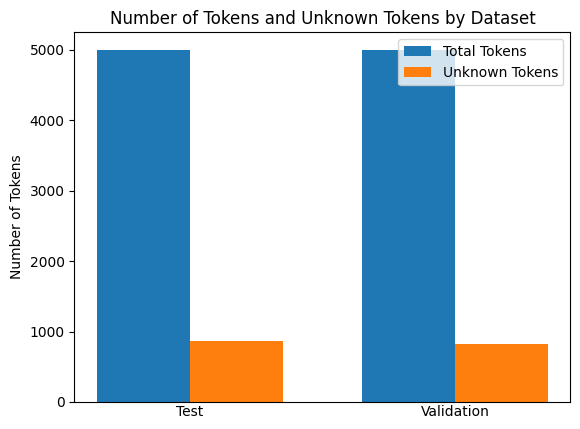

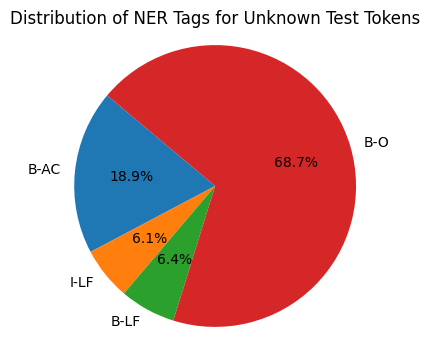

In [209]:
nertags = ['B-O', 'B-AC', 'B-LF', 'I-LF']
split_counts = {'train': {}, 'validation': {}, 'test': {}}

for split in ['train', 'validation', 'test']:
    for row in mydataset[split]:
        ner_counts = row['ner_tags']
        for ner_tag in nertags:
            if ner_tag not in split_counts[split]:
                split_counts[split][ner_tag] = 0
            split_counts[split][ner_tag] += ner_counts.count(ner_tag)

total_counts = {ner_tag: sum(split_counts[split][ner_tag] for split in ['train', 'validation', 'test']) for ner_tag in nertags}

nertags.append('Longforms')

df = pd.DataFrame(index=['Train', 'Test', 'Validation', 'Total'], columns=nertags)

for split in ['train', 'validation', 'test']:
    df.loc[split.capitalize(), : 'I-LF'] = [split_counts[split][ner_tag] for ner_tag in nertags[:-1]]
    df.loc[split.capitalize(), 'Longforms'] = split_counts[split]['B-LF'] + split_counts[split]['I-LF']

df.loc['Total', :'I-LF'] = [total_counts[ner_tag] for ner_tag in nertags[:-1]]
df.loc['Total', 'Longforms'] = total_counts['B-LF'] + total_counts['I-LF']

print(df)

for split in ['train', 'validation', 'test']:
    num_sequences = mydataset[split].num_rows
    print(f"Number of sequences of tokens in {split} split: {num_sequences}")

num_train_tokens = sum(len(row['tokens']) for row in mydataset['train'])
num_test_tokens = sum(len(row['tokens']) for row in mydataset['test'])
num_validation_tokens = sum(len(row['tokens']) for row in mydataset['validation'])

train_tokens = set(token for row in mydataset['train'] for token in row['tokens'])


unknown_tokens_test = sum(1 for row in mydataset['test'] for token in row['tokens'] if token not in train_tokens)
unknown_tokens_validation = sum(1 for row in mydataset['validation'] for token in row['tokens'] if token not in train_tokens)

print("Number of unknown tokens in test dataset:", unknown_tokens_test)
print("Number of unknown tokens in validation dataset:", unknown_tokens_validation)
print("__________")
print("Number of tokens in train dataset:", num_train_tokens)
print("Number of tokens in test dataset:", num_test_tokens)
print("Number of tokens in validation dataset:", num_validation_tokens)

labels = ['Test', 'Validation']
unknown_tokens = [unknown_tokens_test, unknown_tokens_validation]
total_tokens = [num_test_tokens, num_validation_tokens]

x = range(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x, total_tokens, width, label='Total Tokens')
rects2 = ax.bar([i + width for i in x], unknown_tokens, width, label='Unknown Tokens')

for i, rect in enumerate(rects1):
    ax.text(rect.get_x() + rect.get_width() , -200, labels[i], ha='center')

ax.set_ylabel('Number of Tokens')
ax.set_title('Number of Tokens and Unknown Tokens by Dataset')
ax.legend()
ax.set_xticks([])
ax.set_xticklabels([])
plt.show()

unk_test_ner_tags = []

for row in mydataset['test']:
    for i, token in enumerate(row['tokens']):
        if token not in train_tokens:
            unk_test_ner_tags.append(row['ner_tags'][i])

ner_tag_counts = {}
for ner_tag in unk_test_ner_tags:
    ner_tag_counts[ner_tag] = ner_tag_counts.get(ner_tag, 0) + 1

labels = ner_tag_counts.keys()
sizes = ner_tag_counts.values()

plt.figure(figsize=(4, 4))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of NER Tags for Unknown Test Tokens')
plt.axis('equal')
plt.show()


<H2 style="text-align: left">Preparing the Data</H2>

<h3>Embedding</h3>
<p>Experiment no: III , I compared gloVe to fasttext.</p>

In [210]:
glove = downloader.load('glove-wiki-gigaword-50')
#fasttext_model = downloader.load('fasttext-wiki-news-subwords-300')

<p>Indexing the tokens and implementing padding and unknown tokens.</p>

In [211]:
def index_mapper(dataset):
    token2index = defaultdict(lambda: len(token2index))
    tag2index = defaultdict(lambda: len(tag2index))

    token2index['<PAD>'] = 0
    token2index['<UNK>'] = 1

    for item in dataset:
        for token in item['tokens']:
            token2index[token]
        for tag in item['ner_tags']:
            tag2index[tag]

    return dict(token2index), dict(tag2index)

token2index, tag2index = index_mapper(mydataset['train'])
index2token = {index: token for token, index in token2index.items()}
index2tag = {index: tag for tag, index in tag2index.items()}


<p>Dataset class which also handles UNK tokens and indice to tensor conversion.</p>

In [212]:
class DatasetClass(Dataset):
    def __init__(self, data, token2index, tag2index):
        self.data = data
        self.token2index = token2index
        self.tag2index = tag2index

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        dummy = self.data[idx]
        tokens=[]
        ner_tags=[]
        for token in dummy['tokens']:
            token_index = self.token2index.get(token, self.token2index['<UNK>'])
            tokens.append(token_index)
        for tag in dummy['ner_tags']:
            tag_index = self.tag2index[tag]
            ner_tags.append(tag_index)

        token_tensor = torch.tensor(tokens, dtype=torch.long)
        tag_tensor = torch.tensor(ner_tags, dtype=torch.long)

        return token_tensor, tag_tensor

<p>Initialization of pre-trained embedding models for each token.</p>

In [213]:
embedding_dim = 50
#embedding_dim = 300

vocab_size = len(token2index)
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, idx in token2index.items():
    try:
        embedding_matrix[idx] = glove[word]
        #embedding_matrix[idx] = fasttext_model[word]
    except KeyError:
        embedding_matrix[idx] = np.random.normal(scale=0.6, size=(embedding_dim, ))
embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float)


<p>Creation of the train, validation and test datasets</p>

In [214]:
train_dataset = DatasetClass(mydataset['train'], token2index, tag2index)
val_dataset = DatasetClass(mydataset['validation'], token2index, tag2index)
test_dataset = DatasetClass(mydataset['test'], token2index, tag2index)

<p>Custom collate function for padding and data loaders.</p>

In [215]:
def colate(batch):
    token_tensors, tag_tensors = zip(*batch)
    lengths = torch.tensor([len(t) for t in token_tensors])
    token_tensors_padded = pad_sequence(token_tensors, batch_first=True, padding_value=0)
    tag_tensors_padded = pad_sequence(tag_tensors, batch_first=True, padding_value=-1)
    return token_tensors_padded, tag_tensors_padded, lengths

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=colate)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=colate)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=colate)


<h2>Models</h2>
<p>For experiment no II, I will be comparing bidirectional LSTM to vanilla RNN. </p>
<p>In my LSTM model, I will be utilising bidirecitonality to capture context from both directions. I also implemented layer normalisation to stabilize training and dropout layer to prevent overfitting. </p>

In [216]:
class RNNwithLSTM(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, output_dim, n_layers, bidirectional=True, dropout_rate=0.5):
        super(RNNwithLSTM, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers,
                            batch_first=True, bidirectional=bidirectional, dropout=dropout_rate if n_layers > 1 else 0)
        self.layer_norm = nn.LayerNorm(hidden_dim * 2 if bidirectional else hidden_dim)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)


    def forward(self, x, lengths):
        x = self.embedding(x)
        x = self.dropout(x)

        x_packed = pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_output, (hidden, cell) = self.lstm(x_packed)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)
        output = self.layer_norm(output)
        output = self.dropout(output)
        output = self.fc(output)

        return output

<p>As my second model, I will be using a simpler RNN unit, without extra dropout or normalisation layers.</p>

In [ ]:
class RNNdefault(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers):
        super(RNNdefault, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, lengths):
        x = self.embedding(x)
        x_packed = pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_output, _ = self.rnn(x_packed)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)
        output = self.fc(output)
        return output

<h2>Choice of Loss Function, Optimiser and Model</h2>
<p>This is the part we assign our model, optimiser and loss function.</p>

<p>For Experimentation V, I will be testing 2 different optimiser and 2 different loss function.</p>
<p>For optimisers; I will be comparing SGD to Adam.</p>
<p>For loss functions; I will be comparing Cross Entropy Loss to Multiclass Hinge Loss </p>

In [217]:
#model = RNNdefault(vocab_size=len(token2index), embedding_dim=50, hidden_dim=128, output_dim=len(tag2index), n_layers=1).to(device)
model = RNNwithLSTM(embedding_matrix=embedding_matrix, hidden_dim=128, output_dim=len(tag2index), n_layers=1).to(device)
optimizer = optim.Adam(model.parameters(),lr=0.003)
#optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
#loss_fn = torchmetrics.classification.MulticlassHingeLoss(num_classes=len(tag2index),ignore_index=-1).to(device)
loss_fn = nn.CrossEntropyLoss(ignore_index=-1).to(device)

<h2>Hyperparameter Optimisation: LR Finder</h2>
<p>For experimentation VI, I created my own LR Finder, which is compact version of my train loop that records loss and compares the results for the given learning rates.</p>

In [ ]:
loss_tryouts =[0.0001, 0.0003, 0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.01, 0.03, 0.05, 0.1, 0.3, 0.5]
loss2lr = {}

for target_lr in loss_tryouts:
    print(target_lr)

    new_model = RNNwithLSTM(embedding_matrix=embedding_matrix, hidden_dim=128, output_dim=len(tag2index), n_layers=1)
    new_optimizer = optim.Adam(new_model.parameters(), lr=target_lr)
    #new_optimizer = optim.SGD(model.parameters(), lr=target_lr, momentum=0.9)
    new_model.to(device)
    new_model.train()

    for i in range(5):
        total_train_loss = 0
        for tokens, ner_tags, lengths in train_loader:
            tokens, ner_tags = tokens.to(device), ner_tags.to(device)
            new_optimizer.zero_grad()
            outputs = new_model(tokens, lengths)
            outputs_reshaped = outputs.view(-1, outputs.shape[-1])
            ner_tags_reshaped = ner_tags.view(-1)

            loss = loss_fn(outputs_reshaped, ner_tags_reshaped)
            loss.backward()
            new_optimizer.step()

            total_train_loss += loss.item()
        average_train_loss = total_train_loss / (len(train_loader) - 1)

    loss2lr[average_train_loss] = target_lr
print(loss2lr)

<p>Visualisation of LR finder results. Which gave us the expected "U"-shaped curve. Since this approach only include training, we need are going to experiment the lower end values of the curve on the real model, to see how It performs on the unseen data. </p>

In [ ]:
plt.figure(figsize=(10, 8))
plt.plot(loss2lr.values(), loss2lr.keys(), marker='o', linestyle='-')
plt.title('Average Training Loss vs Learning Rate')
plt.xlabel('LR')
plt.ylabel('Loss')
plt.xscale('log')
plt.grid(True)
plt.show()

min_loss_lr = loss2lr[min(loss2lr.keys())]

print("Lowest loss at LR:", min_loss_lr)

<h2>Training Testing and Validation Functions</h2>
<p>Here is our train, test and validation functions which also includes accuracy and F1 calculations.</p>

In [218]:
def train_epoch(model, data_loader, optimizer, loss_fn):
    model.train()
    model.to(device)
    total_train_loss = 0
    all_predictions = []
    all_true_labels = []

    for tokens, ner_tags, lengths in data_loader:
        tokens, ner_tags = tokens.to(device), ner_tags.to(device)
        optimizer.zero_grad()
        outputs = model(tokens, lengths)
        outputs_reshaped = outputs.view(-1, outputs.shape[-1])
        ner_tags_reshaped = ner_tags.view(-1)

        loss = loss_fn(outputs_reshaped, ner_tags_reshaped)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        #logits to preds
        predictions = torch.argmax(outputs_reshaped, dim=1)
        #remove padding
        valid_indices = ner_tags_reshaped != -1
        all_predictions.extend(predictions[valid_indices].tolist())
        all_true_labels.extend(ner_tags_reshaped[valid_indices].tolist())

    avg_loss = total_train_loss / len(data_loader)
    f1 = f1_score(all_true_labels, all_predictions, average='macro')
    accuracy = (sum(int(pred == true) for pred, true in zip(all_predictions, all_true_labels)) / len(all_true_labels)) * 100
    return avg_loss, accuracy, f1

def validation(model, data_loader, loss_fn):
    model.eval()
    model.to(device)
    total_loss = 0
    all_predictions = []
    all_true_labels = []

    with torch.no_grad():
        for tokens, ner_tags, lengths in data_loader:
            tokens, ner_tags = tokens.to(device), ner_tags.to(device)
            outputs = model(tokens, lengths)
            outputs_reshaped = outputs.view(-1, outputs.shape[-1])
            ner_tags_reshaped = ner_tags.view(-1)

            loss = loss_fn(outputs_reshaped, ner_tags_reshaped)
            total_loss += loss.item()
            #logits to preds
            predictions = torch.argmax(outputs_reshaped, dim=1)
            #remove padding
            valid_indices = ner_tags_reshaped != -1
            all_predictions.extend(predictions[valid_indices].tolist())
            all_true_labels.extend(ner_tags_reshaped[valid_indices].tolist())

    avg_loss = total_loss / len(data_loader)
    f1 = f1_score(all_true_labels, all_predictions, average='macro')
    accuracy = (sum(int(pred == true) for pred, true in zip(all_predictions, all_true_labels)) / len(all_true_labels)) * 100
    return avg_loss, accuracy, f1


def test_and_stats(model, data_loader, loss_fn, index2token, index2tag):
    model.eval()
    model.to(device)
    total_loss = 0
    all_predictions = []
    all_true_labels = []
    all_tokens = []

    with torch.no_grad():
        for tokens, ner_tags, lengths in data_loader:
            tokens, ner_tags = tokens.to(device), ner_tags.to(device)
            outputs = model(tokens, lengths)
            outputs_reshaped = outputs.view(-1, outputs.shape[-1])
            ner_tags_reshaped = ner_tags.view(-1)
            loss = loss_fn(outputs_reshaped, ner_tags_reshaped)
            total_loss += loss.item()
            #logits to preds
            predictions = torch.argmax(outputs_reshaped, dim=1)
            #remove padding
            valid_indices = ner_tags_reshaped != -1
            all_tokens.extend(tokens.view(-1)[valid_indices].tolist())
            all_predictions.extend(predictions[valid_indices].tolist())
            all_true_labels.extend(ner_tags_reshaped[valid_indices].tolist())

    avg_loss = total_loss / len(data_loader)
    accuracy = (sum(int(pred == true) for pred, true in zip(all_predictions, all_true_labels)) / len(all_true_labels)) * 100
    return avg_loss, accuracy, all_tokens, all_true_labels, all_predictions


<h2>Visualisation of Results</h2>
<p>Our precision recall curve, confusion matrix and loss per epoch graph functions for evaluating the model at the end.</p>

In [219]:
def plot_precision_recall_curve(y_true, y_pred):
    precision, recall, _ = precision_recall_curve(y_true, y_pred, pos_label=1)
    plt.figure(figsize=(10, 8))
    plt.plot(recall, precision, marker='.')
    plt.title('Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.show()

def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[index2tag[label] for label in labels])
    plt.figure(figsize=(10, 10))
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 8))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss per Epoch')
    plt.legend()
    plt.show()

<h2>Loops and Conclusion</h2>
<p>This includes our train and validation loop with visualisation at the end.</p>
<p>For testing, we also calculate the f1 score correctly by combining longform predictions while ignoring their "beginning" or "inside" tags. We can also see the last 10 mistakes of the testing phase, to understand the intuition of the model on the given tokens.</p>

Epoch 1: Train Loss: 0.6531, Train Acc: 79.48%, Train F1: 0.3226, Val Loss: 0.3699, Val Acc: 86.30%, Val F1: 0.3733
Epoch 2: Train Loss: 0.4304, Train Acc: 84.35%, Train F1: 0.4955, Val Loss: 0.3236, Val Acc: 89.42%, Val F1: 0.6288
Epoch 3: Train Loss: 0.3683, Train Acc: 86.38%, Train F1: 0.6002, Val Loss: 0.2955, Val Acc: 90.16%, Val F1: 0.6136
Epoch 4: Train Loss: 0.3336, Train Acc: 88.00%, Train F1: 0.6582, Val Loss: 0.2881, Val Acc: 90.52%, Val F1: 0.6945
Epoch 5: Train Loss: 0.3014, Train Acc: 88.97%, Train F1: 0.6902, Val Loss: 0.2619, Val Acc: 91.46%, Val F1: 0.7125
Epoch 6: Train Loss: 0.2695, Train Acc: 90.00%, Train F1: 0.7293, Val Loss: 0.2563, Val Acc: 91.42%, Val F1: 0.7199
Epoch 7: Train Loss: 0.2535, Train Acc: 90.69%, Train F1: 0.7448, Val Loss: 0.2429, Val Acc: 92.12%, Val F1: 0.7336
Epoch 8: Train Loss: 0.2289, Train Acc: 91.69%, Train F1: 0.7750, Val Loss: 0.2436, Val Acc: 92.04%, Val F1: 0.7403
Epoch 9: Train Loss: 0.2171, Train Acc: 92.00%, Train F1: 0.7821, Val Lo

<Figure size 1000x1000 with 0 Axes>

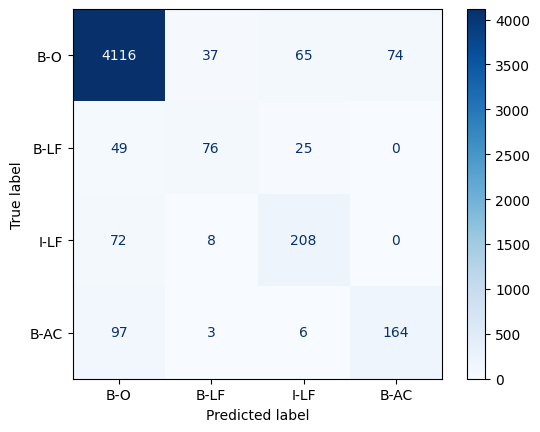

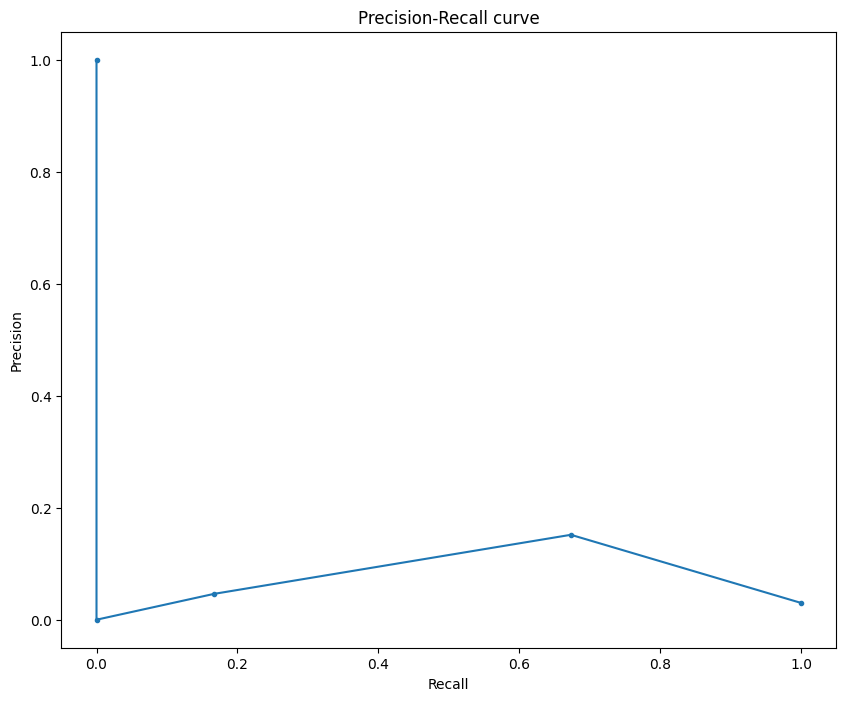

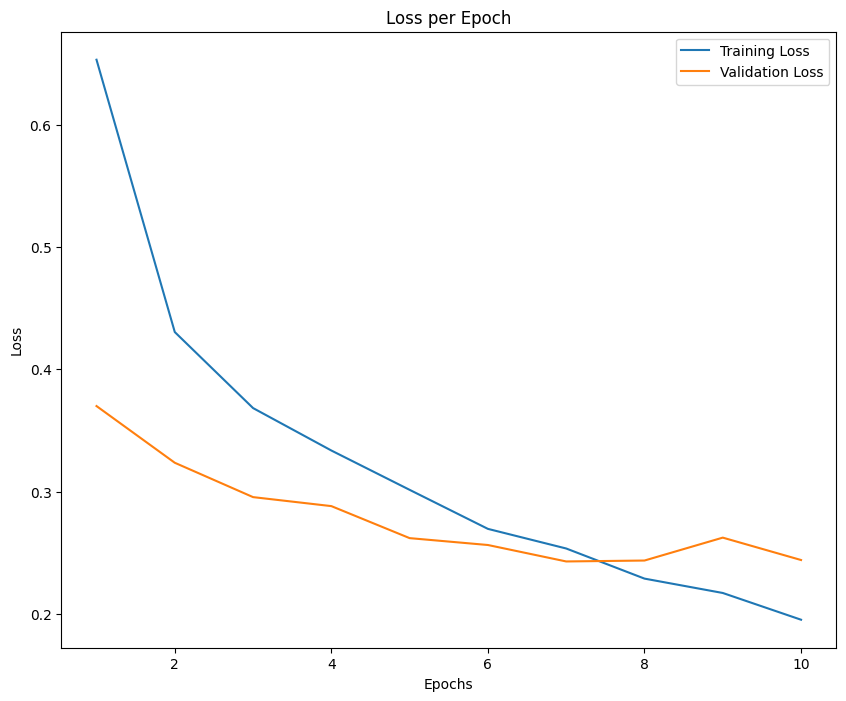

In [220]:
train_losses = []
val_losses = []
epochs = 10
for epoch in range(epochs):
    avg_train_loss, train_accuracy, train_f1 = train_epoch(model, train_loader, optimizer, loss_fn)
    avg_val_loss, val_accuracy, val_f1 = validation(model, val_loader, loss_fn)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    print(f'Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Train F1: {train_f1:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%, Val F1: {val_f1:.4f}')


#test
avg_test_loss, test_accuracy, test_tokens, test_true_labels, test_predictions = test_and_stats(model, test_loader, loss_fn, index2token, index2tag)

f1_true_labels = test_true_labels.copy()
f1_predictions = test_predictions.copy()

for i in range(len(f1_true_labels)):
    if f1_true_labels[i] == 1 and f1_predictions[i] == 2:
        f1_predictions[i] = 1
    elif f1_true_labels[i] == 2 and f1_predictions[i] == 1:
        f1_predictions[i] = 2

print(f1_true_labels)
print(f1_predictions)

test_f1_dk = f1_score(f1_true_labels, f1_predictions, average='macro')
print(f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%, Test F1(true): {test_f1_dk:.4f}')
test_f1 = f1_score(test_true_labels, test_predictions, average='macro')
print(f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%, Test F1: {test_f1:.4f}')

#print last 10 mistake in testing
errors = [(index2token[tok], index2tag[pred], index2tag[true]) for tok, pred, true in zip(test_tokens, test_predictions, test_true_labels) if pred != true]
print("\n Last 10 Classification Errors on Test Set:")
for token, pred, correct in errors[-10:]:
    print(f"Token: '{token}', Predicted: '{pred}', Correct: '{correct}'")

unique_labels = np.unique(test_true_labels + test_predictions)

plot_confusion_matrix(test_true_labels, test_predictions, labels=unique_labels)

plot_precision_recall_curve(test_true_labels, test_predictions)

plot_losses(train_losses, val_losses)